<p style="padding: 10px;
          font-size:50px;
          font-weight: bolder;
          color: rgba(124, 203, 234, 0.75)">
    Laboratory Task 1
</p>

<a name="000" style="color: black">
    <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
        Table of Contents
    </p>
</a>

<div style="padding: 20px;
            margin-top: 20px;
            color: black;
            background: rgba(124,203,234,0.25)">
    <ol>
        <li><a href="#001">Option 1: Regression Model</a></li>
        <li><a href="#002">Option 2: Time Series Model</a></li>
    </ol>
</div>

In [1]:
# !pip install eli5 xgboost statsmodels pmdarima

In [2]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import pickle
import eli5

import pmdarima
from sklearn.utils import shuffle
from statsmodels.tsa.arima.model import ARIMA
from eli5.sklearn import PermutationImportance
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

warnings.filterwarnings(action="ignore")
sns.set_theme(style="whitegrid", palette="pastel")
%matplotlib inline

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="001" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Option 1: Regression Model
        </p>
    </a>
</blockquote>

In [16]:
train_data = pd.read_csv("src\\reg_train.csv",
    dtype={
        "lon": np.float16, "lat": np.float16, "sum": np.int16,
        "year": np.int16, "month": np.int16, "day": np.int16,
        "hour": np.int16, "weekday": np.int16, "weekend": np.int16,
        "holiday": np.int16, "point_id": np.int16
    })

test_data = pd.read_csv("src\\reg_test.csv",
    dtype={
        "lon": np.float16, "lat": np.float16, "sum": np.int16,
        "year": np.int16, "month": np.int16, "day": np.int16,
        "hour": np.int16, "weekday": np.int16, "weekend": np.int16,
        "holiday": np.int16, "point_id": np.int16, "error": np.float16
    })

valid_data = pd.read_csv("src\\reg_valid.csv",
    dtype={
        "lon": np.float16, "lat": np.float16, "sum": np.int16,
        "year": np.int16, "month": np.int16, "day": np.int16,
        "hour": np.int16, "weekday": np.int16, "weekend": np.int16,
        "holiday": np.int16, "point_id": np.int16, "error": np.float16
    })

train_data.head()

,lon,lat,sum,year,month,day,hour,weekday,weekend,holiday,point_id
0,30.250000,60.03125,1,2019,1,1,0,1,0,1,0
1,30.250000,59.84375,1,2019,1,1,0,1,0,1,1
2,30.234375,59.96875,1,2019,1,1,0,1,0,1,2
3,30.234375,59.84375,2,2019,1,1,0,1,0,1,3
4,30.234375,60.03125,1,2019,1,1,0,1,0,1,4


In [17]:
X_train = train_data.drop(["sum"], axis=1)
print(f"Dataset shape: {X_train.shape}")
y_train = train_data[["sum"]]

X_test = test_data.drop(["sum", "error"], axis=1)
X_test = X_test.loc[:, X_train.columns]
print(f"Dataset shape: {X_test.shape}")
y_test = test_data[["sum"]]

X_valid = valid_data.drop(["sum", "error"], axis=1)
X_valid = X_valid.loc[:, X_train.columns]
print(f"Dataset shape: {X_valid.shape}")
y_valid = valid_data[["sum"]]

Dataset shape: (3623620, 10)
Dataset shape: (700, 10)
Dataset shape: (686, 10)


Shuffling the training dataset.

In [5]:
X_train, y_train = shuffle(X_train, y_train)

Train an XGBRegressor based on decision trees with default parameters.

In [6]:
xgb = XGBRegressor(n_jobs=-1)
xgb_stat = xgb.fit(X_train, y_train)
xgb_stat.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)>

Calculate metrics on a test dataset.

In [7]:
prediction = xgb_stat.predict(X_test)

print("Test MAE: {:.5f}".format(mean_absolute_error(prediction, y_test)))
print("Test MSE: {:.5f}".format(mean_squared_error(prediction, y_test)))
print("Test R2: {:.5f}".format(r2_score(prediction, y_test)))

Test MAE: 4.40955
Test MSE: 44.29930
Test R2: 0.08080


Calculate metrics on a valid dataset.

In [8]:
prediction = xgb_stat.predict(X_valid)

print("Valid MAE: {:.5f}".format(mean_absolute_error(prediction, y_valid)))
print("Valid MSE: {:.5f}".format(mean_squared_error(prediction, y_valid)))
print("Valid R2: {:.5f}".format(r2_score(prediction, y_valid)))

Valid MAE: 4.54367
Valid MSE: 40.53892
Valid R2: 0.23456


Calculate total (Lab) metric on a valid dataset.

In [9]:
custom_loss = []
y_valid = y_valid["sum"].tolist()

for idx, value in enumerate(prediction):
    custom_loss.append(abs(value-y_valid[idx])/value)

print("Valid Loss for Lab (should not exceed 2.6): {:.5f}".format(np.array(custom_loss).mean()))

Valid Loss for Lab (should not exceed 2.6): 0.99671


Let's see how well the model predicts the number of publications on the validation dataset.

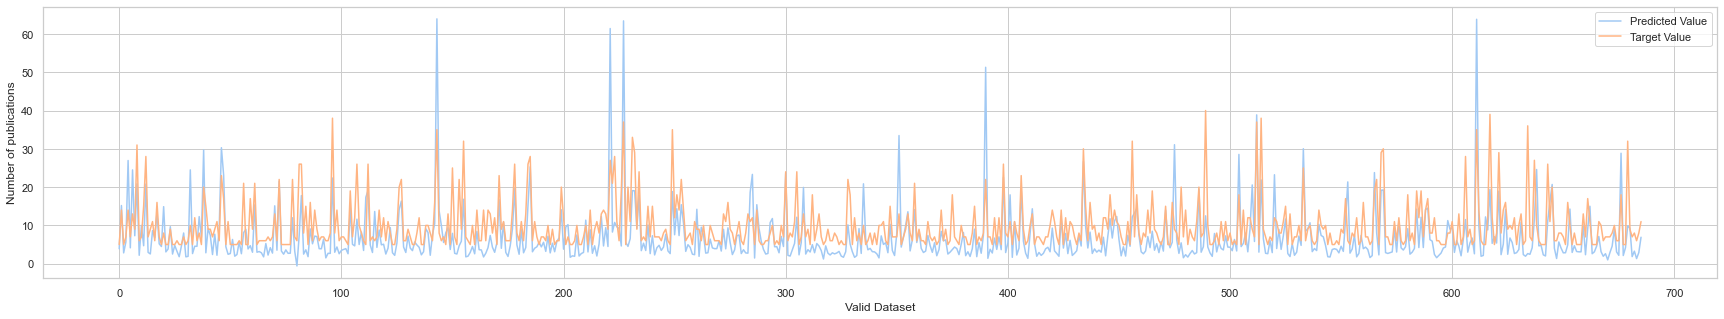

In [10]:
plt.figure(figsize=(30, 5))
plt.plot(prediction, label="Predicted Value")
plt.plot(y_valid, label="Target Value")
plt.ylabel("Number of publications")
plt.xlabel("Valid Dataset")
plt.legend()
plt.show()

Calculate the importance of features for the trained model.

In [11]:
importance = PermutationImportance(xgb_stat, random_state=42).fit(X_valid, y_valid)
eli5.show_weights(importance, feature_names=X_valid.columns.tolist())

Weight,Feature
1.6080 ± 0.0914,point_id
0.3135 ± 0.0800,hour
0.1022 ± 0.0154,lon
0.0425 ± 0.0217,lat
0.0180 ± 0.0158,weekday
0 ± 0.0000,weekend
0 ± 0.0000,month
0 ± 0.0000,year
-0.0133 ± 0.0241,holiday
-0.0173 ± 0.0470,day


Let's try to tune the model using parameter enumeration to improve the prediction. Executing the cell below will take several hours.

In [ ]:
# xgb = XGBRegressor(n_jobs=-1)

# xgb_param_grid = {
#     "max_depth": [5, 10, 15],
#     "learning_rate": [0.15, 0.3, 0.5],
#     "max_leaves": [7, 14, 21, 28],
#     "n_estimators": [100, 200, 300, 400]
# }

# xgb_regressor = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, scoring="neg_mean_absolute_error", cv=2, verbose=True)
# best_xgb = xgb_regressor.fit(X_train, y_train)
# best_xgb.best_params_

Let's use the parameters obtained during tuning to improve the accuracy of the model.

In [12]:
xgb = XGBRegressor(n_jobs=-1, n_estimators=300, max_leaves=30, max_depth=20)
best_xgb = xgb.fit(X_train, y_train)
best_xgb.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=20, max_leaves=30, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)>

Calculate metrics on a test dataset.

In [18]:
prediction = best_xgb.predict(X_test)

print("Test MAE: {:.5f}".format(mean_absolute_error(prediction, y_test)))
print("Test MSE: {:.5f}".format(mean_squared_error(prediction, y_test)))
print("Test R2: {:.5f}".format(r2_score(prediction, y_test)))

Test MAE: 4.68733
Test MSE: 72.31047
Test R2: 0.30574


Calculate metrics on a valid dataset.

In [19]:
prediction = best_xgb.predict(X_valid)

print("Valid MAE: {:.5f}".format(mean_absolute_error(prediction, y_valid)))
print("Valid MSE: {:.5f}".format(mean_squared_error(prediction, y_valid)))
print("Valid R2: {:.5f}".format(r2_score(prediction, y_valid)))

Valid MAE: 4.83880
Valid MSE: 74.96082
Valid R2: 0.38378


Calculate total (Lab) metric on a valid dataset.

In [20]:
custom_loss = []
y_valid = y_valid["sum"].tolist()

for idx, value in enumerate(prediction):
    custom_loss.append(abs(value-y_valid[idx])/value)

print("Valid Loss for Lab (should not exceed 2.6): {:.5f}".format(np.array(custom_loss).mean()))

Valid Loss for Lab (should not exceed 2.6): 1.21221


In [21]:
importance = PermutationImportance(best_xgb, random_state=42).fit(X_test, y_test)
eli5.show_weights(importance, feature_names=X_test.columns.tolist())

Weight,Feature
1.3740 ± 0.2388,point_id
0.7588 ± 0.5355,hour
0.6185 ± 0.3331,lon
0.4179 ± 0.6662,weekday
0.2290 ± 0.7039,day
0.1011 ± 0.3632,lat
0.0206 ± 0.0408,holiday
0 ± 0.0000,weekend
0 ± 0.0000,month
0 ± 0.0000,year


In [22]:
importance = PermutationImportance(best_xgb, random_state=42).fit(X_valid, y_valid)
eli5.show_weights(importance, feature_names=X_valid.columns.tolist())

Weight,Feature
1.2262 ± 0.4942,point_id
0.7757 ± 1.2172,hour
0.5767 ± 0.7602,weekday
0.5653 ± 0.1627,lon
0.2498 ± 0.2115,lat
0.0150 ± 0.0514,holiday
0 ± 0.0000,weekend
0 ± 0.0000,month
0 ± 0.0000,year
-0.3005 ± 0.1834,day


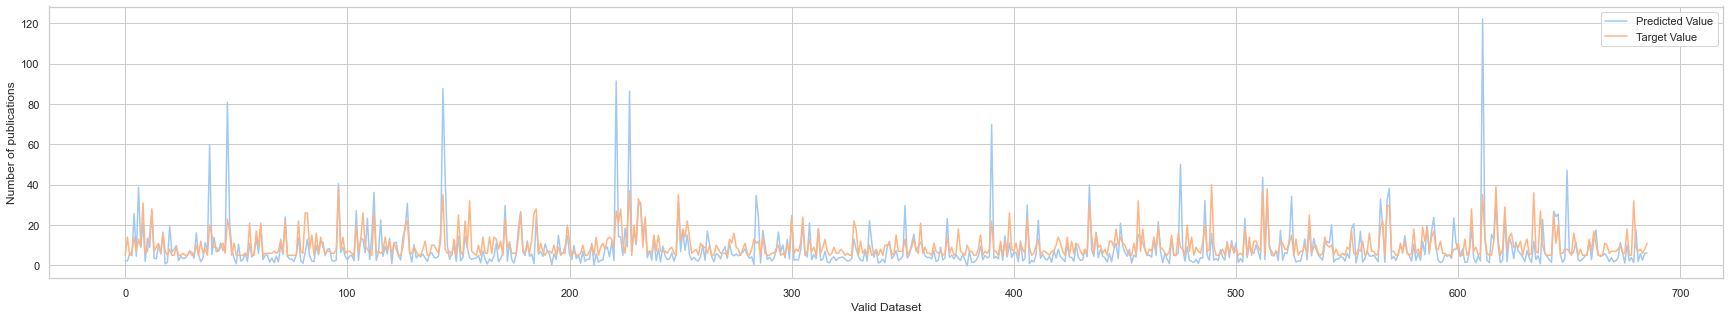

In [23]:
plt.figure(figsize=(30, 5))
plt.plot(prediction, label="Predicted Value")
plt.plot(y_valid, label="Target Value")
plt.ylabel("Number of publications")
plt.xlabel("Valid Dataset")
plt.legend()
plt.show()

The old model better approximates feature knowledge. Let's export it.

In [24]:
with open("src\\xgb_model.pkl", "wb") as fp:
    pickle.dump(xgb_stat, fp)

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="002" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Option 2: Time Series Model
        </p>
    </a>
</blockquote>

In [11]:
train_data = pd.read_csv("src\\time_train.csv", parse_dates=["datetime"], index_col=["datetime"], encoding="cp1251")
test_data = pd.read_csv("src\\time_test.csv", parse_dates=["datetime"], index_col=["datetime"], encoding="cp1251")
valid_data = pd.read_csv("src\\time_valid.csv", parse_dates=["datetime"], index_col=["datetime"], encoding="cp1251")

train_data.head()

,sum
datetime,
2019-01-01 00:00:00,479
2019-01-01 01:00:00,363
2019-01-01 02:00:00,244
2019-01-01 03:00:00,141
2019-01-01 04:00:00,85


Hypothesis: number of publications is a stationary series and has a seasonality, which allows to consider it as a time series.

In [4]:
arima_model = pmdarima.arima.ARIMA(order=(2, 0, 2), seasonal_order=(2, 0, 2, 24))
arima_trained = arima_model.fit(train_data["sum"])

Let's train and test autoregressive model.

In [5]:
forecast = arima_trained.predict(
    start= len(train_data),
    end = (len(train_data)-1)+300,
    typ ="levels"
).rename("forecast")

In [6]:
forecast_data = pd.DataFrame(forecast)
forecast_data["datetime"] = forecast_data.index
forecast_data.reset_index(inplace=True, drop=True)

valid_data["datetime"] = valid_data.index
valid_data.reset_index(inplace=True, drop=True)

In [ ]:
val = valid_data.merge(forecast_data, how="inner", on="datetime")

In [9]:
print("Test MAE: {:.5f}".format(mean_absolute_error(val["forecast"].tolist(), val["sum"].tolist())))
print("Test R2: {:.5f}".format(r2_score(val["forecast"].tolist(), val["sum"].tolist())))

Test MAE: 1324.41162
Test R2: nan


In [5]:
sarimax_model = SARIMAX(train_data["sum"], order=(0, 1, 1), seasonal_order=(2, 1, 1, 12))

trained_sarimax = sarimax_model.fit()
trained_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                sum   No. Observations:                 9504
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood              -55283.972
Date:                            Sat, 12 Nov 2022   AIC                         110577.945
Time:                                    13:34:11   BIC                         110613.735
Sample:                                01-01-2019   HQIC                        110590.091
                                     - 01-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0733      0.008     -9.337      0.000      -0.089      -0.058
ar.S.L12      -0.4723      0.007    -69.416      0.000      -0.486      -0.459
ar.S.L24       0.5277      0.007     77.133      0.000       0.514       0.541
ma.S.L12      -0.9699      0.003   -380.661      0.000      -0.975      -0.965
sigma2      6664.4932     58.362    114.191      0.000    6550.105    6778.882
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              7642.81
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
forecast = trained_sarimax.predict(
    start= len(train_data),
    end = (len(train_data)-1)+300,
    typ ="levels"
).rename("forecast")

In [8]:
forecast_data = pd.DataFrame(forecast)
forecast_data["datetime"] = forecast_data.index
forecast_data.reset_index(inplace=True, drop=True)

valid_data["datetime"] = valid_data.index
valid_data.reset_index(inplace=True, drop=True)

In [9]:
val = valid_data.merge(forecast_data, how="inner", on="datetime")
val.head()

,sum,datetime,forecast
0,12,2020-02-01 09:00:00,1330.797608
1,23,2020-02-01 10:00:00,1368.853695
2,39,2020-02-01 11:00:00,1411.598881
3,14,2020-02-01 12:00:00,1380.769398
4,26,2020-02-01 13:00:00,1370.806339


In [10]:
print("Test MAE: {:.5f}".format(mean_absolute_error(val["forecast"].tolist(), val["sum"].tolist())))
print("Test R2: {:.5f}".format(r2_score(val["forecast"].tolist(), val["sum"].tolist())))

Test MAE: 1341.23446
Test R2: -21.73401


The hypothesis has been disproved. The series is not stationary. As a result of the experiment, it was found that it is more expedient to use a XGBoost regressor to predict the number of publications.